In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import shap

In [2]:
def plot(df, min_time, max_time):
    df = df.loc[(df.index >= min_time) & (df.index <= max_time)]
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(df.index, df.login_time)
    ax.set_title("logins over time")
    ax.set_xlabel("time")
    indices = list(range(0, len(df), 96))
    xticks = [df.index[i] for i in indices]
    xlabels = [df.iloc[i].day_of_week for i in indices]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=45)
    plt.show()


def plot_stacked_bar(df, feature, target):
    df["pivot_dummy"] = 1
    pivot_df = df.pivot_table(values=["pivot_dummy"], columns=[target], index=[feature], aggfunc="count")
    pivot_df = pivot_df.div(pivot_df.sum(1), axis=0)
    pivot_df = pivot_df.droplevel(0, axis=1)
    # puts True before (below) False
    pivot_df = pivot_df.sort_values(target, axis=1, ascending=False)
    pivot_df = pivot_df.sort_values(True, ascending=False)
    pivot_df.plot(kind="bar", stacked=True)

    
def plot_dists(df, feature, target):
    target_false_df = df[~df[target]]
    target_true_df = df[df[target]]
    sns.distplot(target_true_df[feature], color="b", label=target)
    sns.distplot(target_false_df[feature], color="r", label=("not " + target))


In [3]:
df = pd.read_json("ultimate_data_challenge.json")

In [4]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [5]:
df.last_trip_date.max()

'2014-07-01'

In [6]:
_30_days = timedelta(days=30)
pd.to_datetime(df.last_trip_date.max()) - _30_days

Timestamp('2014-06-01 00:00:00')

In [4]:
last_date = pd.to_datetime(df.last_trip_date.max())
df["retained"] = pd.to_datetime(df.last_trip_date) >= (last_date - timedelta(days=30))

In [5]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [9]:
len(df[df["retained"]])/len(df)

0.37608

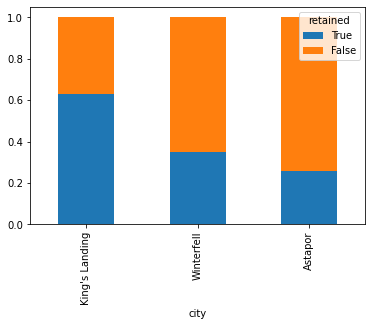

In [10]:
plot_stacked_bar(df, feature="city", target="retained")

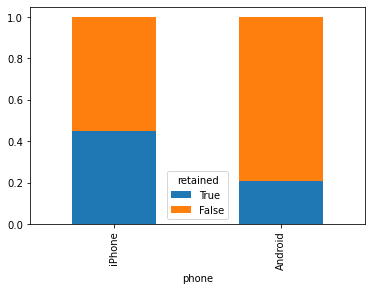

In [11]:
plot_stacked_bar(df, feature="phone", target="retained")

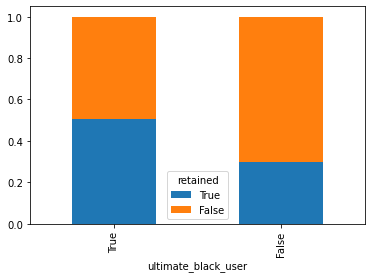

In [12]:
plot_stacked_bar(df, feature="ultimate_black_user", target="retained")

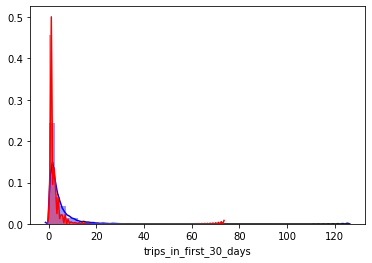

In [13]:
plot_dists(df, feature="trips_in_first_30_days", target="retained")

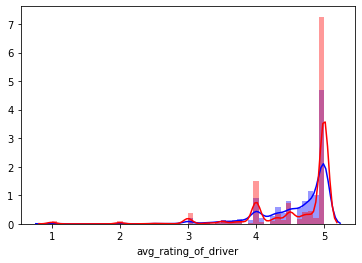

In [14]:
plot_dists(df, feature="avg_rating_of_driver", target="retained")

/home/pky/anaconda3/envs/take_home/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


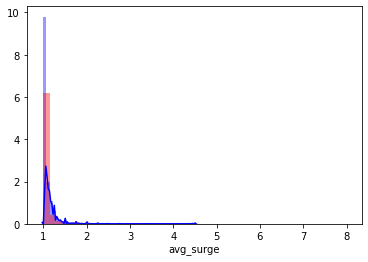

In [15]:
plot_dists(df, feature="avg_surge", target="retained")

/home/pky/anaconda3/envs/take_home/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


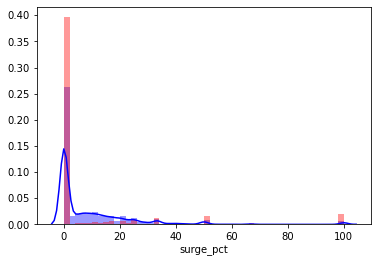

In [16]:
plot_dists(df, feature="surge_pct", target="retained")

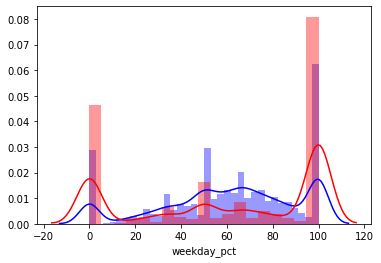

In [17]:
plot_dists(df, feature="weekday_pct", target="retained")

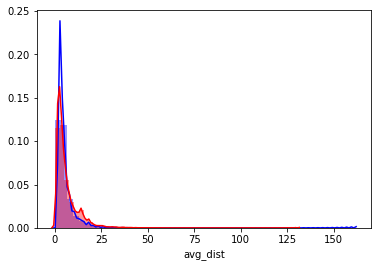

In [18]:
plot_dists(df, feature="avg_dist", target="retained")

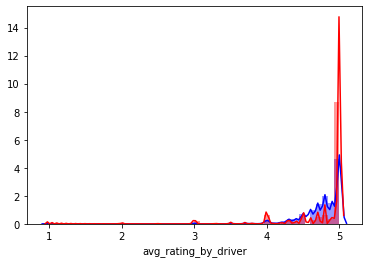

In [19]:
plot_dists(df, feature="avg_rating_by_driver", target="retained")

In [21]:
df = df.drop("pivot_dummy", axis=1)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [22]:
df[~df["retained"]]["avg_rating_of_driver"].mean()

4.607556868776815

In [23]:
df[df["retained"]]["avg_rating_of_driver"].mean()

4.592930351735383

In [24]:
df[~df["retained"]]["avg_rating_by_driver"].mean()

4.787464148754472

In [25]:
df[df["retained"]]["avg_rating_by_driver"].mean()

4.762771739130435

In [6]:
df[df["retained"]]["trips_in_first_30_days"].mean()

3.3063178047223993

In [7]:
df[~df["retained"]]["trips_in_first_30_days"].mean()

1.6584818566482882

In [30]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [32]:
def FillMissing(row, feature, target, false_value, true_value):
    if np.isnan(row[feature]):
        return true_value if row[target] else false_value
    else:
        return row[feature]

df["avg_rating_of_driver"] = df.apply(
    lambda row: FillMissing(row, feature="avg_rating_of_driver", target="retained", false_value=4.6, true_value=4.6),
    axis=1
)

df["avg_rating_by_driver"] = df.apply(
    lambda row: FillMissing(row, feature="avg_rating_by_driver", target="retained", false_value=4.8, true_value=4.8),
    axis=1
)

In [33]:
df.isna().sum()

city                        0
trips_in_first_30_days      0
signup_date                 0
avg_rating_of_driver        0
avg_surge                   0
last_trip_date              0
phone                     396
surge_pct                   0
ultimate_black_user         0
weekday_pct                 0
avg_dist                    0
avg_rating_by_driver        0
retained                    0
dtype: int64

In [37]:
log_reg_df = pd.get_dummies(df, columns=["city", "phone", "ultimate_black_user"])
log_reg_df = log_reg_df.drop(["city_Winterfell", "ultimate_black_user_False", "signup_date", "last_trip_date"], 
                             axis=1)
log_reg_df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,phone_Android,phone_iPhone,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,True,0,1,0,1,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,False,1,0,1,0,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,False,1,0,0,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,True,0,1,0,1,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,False,0,0,1,0,0


In [38]:
X = log_reg_df.drop(["retained"], axis=1)
y = log_reg_df["retained"]

In [50]:
kf = KFold(n_splits=5)
roc_auc_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = LogisticRegression(penalty="l1", solver="liblinear")
    clf.fit(X_train, y_train)
    y_score = np.squeeze(clf.predict_proba(X_test)[:,1])
    roc_auc_scores.append(roc_auc_score(y_test, y_score))

np.mean(roc_auc_scores)

0.7604864512682188

In [52]:
kf = KFold(n_splits=5)
roc_auc_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_score = np.squeeze(clf.predict_proba(X_test)[:,1])
    roc_auc_scores.append(roc_auc_score(y_test, y_score))

np.mean(roc_auc_scores)

0.8206310721907265

In [56]:
kf = KFold(n_splits=5)
roc_auc_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = GradientBoostingClassifier()
    clf.fit(X_train, y_train)
    y_score = np.squeeze(clf.predict_proba(X_test)[:,1])
    roc_auc_scores.append(roc_auc_score(y_test, y_score))

np.mean(roc_auc_scores)

0.8520681366453078

In [58]:
kf = KFold(n_splits=5)
roc_auc_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    param = {}
    bst = xgb.train(param, dtrain)
    y_score = bst.predict(dtest)
    roc_auc_scores.append(roc_auc_score(y_test, y_score))

np.mean(roc_auc_scores)

0.8509394123796732

In [61]:
X = df.drop(["retained", "signup_date", "last_trip_date"], axis=1).fillna("Missing")
y = df["retained"]
categorical_features_indices = np.where((X.dtypes != np.float) & (X.dtypes != np.int))[0]

kf = KFold(n_splits=5)
roc_auc_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = CatBoostClassifier()
    clf.fit(X_train, y_train, cat_features=categorical_features_indices)
    y_score = np.squeeze(clf.predict_proba(X_test)[:,1])
    roc_auc_scores.append(roc_auc_score(y_test, y_score))

np.mean(roc_auc_scores)

Learning rate set to 0.049775
0:	learn: 0.6735269	total: 91.4ms	remaining: 1m 31s
1:	learn: 0.6561660	total: 133ms	remaining: 1m 6s
2:	learn: 0.6406630	total: 170ms	remaining: 56.5s
3:	learn: 0.6245775	total: 218ms	remaining: 54.3s
4:	learn: 0.6109884	total: 257ms	remaining: 51.2s
5:	learn: 0.5987466	total: 281ms	remaining: 46.6s
6:	learn: 0.5859947	total: 308ms	remaining: 43.7s
7:	learn: 0.5759966	total: 331ms	remaining: 41.1s
8:	learn: 0.5673024	total: 362ms	remaining: 39.9s
9:	learn: 0.5597889	total: 395ms	remaining: 39.1s
10:	learn: 0.5529071	total: 433ms	remaining: 39s
11:	learn: 0.5460996	total: 462ms	remaining: 38.1s
12:	learn: 0.5402935	total: 486ms	remaining: 36.9s
13:	learn: 0.5347344	total: 512ms	remaining: 36.1s
14:	learn: 0.5304208	total: 542ms	remaining: 35.6s
15:	learn: 0.5261939	total: 566ms	remaining: 34.8s
16:	learn: 0.5220686	total: 596ms	remaining: 34.4s
17:	learn: 0.5186219	total: 625ms	remaining: 34.1s
18:	learn: 0.5141279	total: 661ms	remaining: 34.1s
19:	learn: 

163:	learn: 0.4504214	total: 5.59s	remaining: 28.5s
164:	learn: 0.4503465	total: 5.62s	remaining: 28.4s
165:	learn: 0.4503459	total: 5.64s	remaining: 28.3s
166:	learn: 0.4502787	total: 5.67s	remaining: 28.3s
167:	learn: 0.4502379	total: 5.7s	remaining: 28.2s
168:	learn: 0.4501188	total: 5.73s	remaining: 28.2s
169:	learn: 0.4501159	total: 5.75s	remaining: 28.1s
170:	learn: 0.4500764	total: 5.79s	remaining: 28.1s
171:	learn: 0.4500212	total: 5.83s	remaining: 28.1s
172:	learn: 0.4499655	total: 5.87s	remaining: 28.1s
173:	learn: 0.4499086	total: 5.9s	remaining: 28s
174:	learn: 0.4498288	total: 5.93s	remaining: 28s
175:	learn: 0.4497500	total: 5.97s	remaining: 28s
176:	learn: 0.4496728	total: 6.01s	remaining: 27.9s
177:	learn: 0.4496459	total: 6.03s	remaining: 27.9s
178:	learn: 0.4496198	total: 6.06s	remaining: 27.8s
179:	learn: 0.4495871	total: 6.1s	remaining: 27.8s
180:	learn: 0.4495059	total: 6.13s	remaining: 27.8s
181:	learn: 0.4493947	total: 6.17s	remaining: 27.7s
182:	learn: 0.4491693

323:	learn: 0.4372777	total: 11.3s	remaining: 23.5s
324:	learn: 0.4372451	total: 11.3s	remaining: 23.5s
325:	learn: 0.4371709	total: 11.3s	remaining: 23.4s
326:	learn: 0.4371152	total: 11.4s	remaining: 23.4s
327:	learn: 0.4370286	total: 11.4s	remaining: 23.4s
328:	learn: 0.4369721	total: 11.5s	remaining: 23.4s
329:	learn: 0.4368882	total: 11.5s	remaining: 23.3s
330:	learn: 0.4368168	total: 11.5s	remaining: 23.3s
331:	learn: 0.4367064	total: 11.6s	remaining: 23.3s
332:	learn: 0.4366401	total: 11.6s	remaining: 23.2s
333:	learn: 0.4365510	total: 11.6s	remaining: 23.2s
334:	learn: 0.4365408	total: 11.7s	remaining: 23.1s
335:	learn: 0.4364226	total: 11.7s	remaining: 23.1s
336:	learn: 0.4363244	total: 11.7s	remaining: 23.1s
337:	learn: 0.4362056	total: 11.8s	remaining: 23s
338:	learn: 0.4361254	total: 11.8s	remaining: 23s
339:	learn: 0.4360440	total: 11.8s	remaining: 22.9s
340:	learn: 0.4359743	total: 11.8s	remaining: 22.9s
341:	learn: 0.4358571	total: 11.9s	remaining: 22.8s
342:	learn: 0.43

483:	learn: 0.4272211	total: 17.3s	remaining: 18.4s
484:	learn: 0.4271963	total: 17.3s	remaining: 18.4s
485:	learn: 0.4271410	total: 17.3s	remaining: 18.3s
486:	learn: 0.4271044	total: 17.4s	remaining: 18.3s
487:	learn: 0.4270649	total: 17.4s	remaining: 18.3s
488:	learn: 0.4270136	total: 17.4s	remaining: 18.2s
489:	learn: 0.4269787	total: 17.5s	remaining: 18.2s
490:	learn: 0.4269292	total: 17.5s	remaining: 18.1s
491:	learn: 0.4268915	total: 17.5s	remaining: 18.1s
492:	learn: 0.4268859	total: 17.6s	remaining: 18.1s
493:	learn: 0.4268343	total: 17.6s	remaining: 18s
494:	learn: 0.4267682	total: 17.6s	remaining: 18s
495:	learn: 0.4267415	total: 17.7s	remaining: 17.9s
496:	learn: 0.4267041	total: 17.7s	remaining: 17.9s
497:	learn: 0.4266667	total: 17.7s	remaining: 17.9s
498:	learn: 0.4265996	total: 17.8s	remaining: 17.8s
499:	learn: 0.4265800	total: 17.8s	remaining: 17.8s
500:	learn: 0.4265125	total: 17.8s	remaining: 17.8s
501:	learn: 0.4264759	total: 17.9s	remaining: 17.7s
502:	learn: 0.42

645:	learn: 0.4202581	total: 23.5s	remaining: 12.9s
646:	learn: 0.4202459	total: 23.5s	remaining: 12.8s
647:	learn: 0.4201985	total: 23.5s	remaining: 12.8s
648:	learn: 0.4201533	total: 23.6s	remaining: 12.7s
649:	learn: 0.4200885	total: 23.6s	remaining: 12.7s
650:	learn: 0.4200152	total: 23.6s	remaining: 12.7s
651:	learn: 0.4199601	total: 23.7s	remaining: 12.6s
652:	learn: 0.4198829	total: 23.7s	remaining: 12.6s
653:	learn: 0.4198294	total: 23.8s	remaining: 12.6s
654:	learn: 0.4197855	total: 23.8s	remaining: 12.5s
655:	learn: 0.4197391	total: 23.8s	remaining: 12.5s
656:	learn: 0.4196881	total: 23.9s	remaining: 12.5s
657:	learn: 0.4196321	total: 23.9s	remaining: 12.4s
658:	learn: 0.4196019	total: 24s	remaining: 12.4s
659:	learn: 0.4195142	total: 24s	remaining: 12.4s
660:	learn: 0.4194566	total: 24s	remaining: 12.3s
661:	learn: 0.4193968	total: 24.1s	remaining: 12.3s
662:	learn: 0.4193922	total: 24.1s	remaining: 12.3s
663:	learn: 0.4193363	total: 24.2s	remaining: 12.2s
664:	learn: 0.4193

806:	learn: 0.4140936	total: 29.5s	remaining: 7.05s
807:	learn: 0.4140602	total: 29.5s	remaining: 7.01s
808:	learn: 0.4139999	total: 29.5s	remaining: 6.97s
809:	learn: 0.4139695	total: 29.5s	remaining: 6.93s
810:	learn: 0.4139206	total: 29.6s	remaining: 6.89s
811:	learn: 0.4139086	total: 29.6s	remaining: 6.86s
812:	learn: 0.4138702	total: 29.7s	remaining: 6.82s
813:	learn: 0.4138549	total: 29.7s	remaining: 6.79s
814:	learn: 0.4138131	total: 29.7s	remaining: 6.75s
815:	learn: 0.4137947	total: 29.8s	remaining: 6.71s
816:	learn: 0.4137426	total: 29.8s	remaining: 6.67s
817:	learn: 0.4137326	total: 29.8s	remaining: 6.64s
818:	learn: 0.4137059	total: 29.9s	remaining: 6.6s
819:	learn: 0.4136815	total: 29.9s	remaining: 6.56s
820:	learn: 0.4136492	total: 30s	remaining: 6.53s
821:	learn: 0.4136154	total: 30s	remaining: 6.49s
822:	learn: 0.4135229	total: 30s	remaining: 6.46s
823:	learn: 0.4134719	total: 30.1s	remaining: 6.42s
824:	learn: 0.4134650	total: 30.1s	remaining: 6.39s
825:	learn: 0.41342

966:	learn: 0.4085359	total: 35.2s	remaining: 1.2s
967:	learn: 0.4085050	total: 35.3s	remaining: 1.17s
968:	learn: 0.4084730	total: 35.3s	remaining: 1.13s
969:	learn: 0.4084263	total: 35.4s	remaining: 1.09s
970:	learn: 0.4083779	total: 35.4s	remaining: 1.06s
971:	learn: 0.4083608	total: 35.4s	remaining: 1.02s
972:	learn: 0.4083159	total: 35.5s	remaining: 985ms
973:	learn: 0.4082508	total: 35.5s	remaining: 948ms
974:	learn: 0.4082452	total: 35.5s	remaining: 912ms
975:	learn: 0.4081914	total: 35.6s	remaining: 875ms
976:	learn: 0.4081595	total: 35.6s	remaining: 839ms
977:	learn: 0.4081097	total: 35.7s	remaining: 802ms
978:	learn: 0.4080883	total: 35.7s	remaining: 766ms
979:	learn: 0.4080488	total: 35.7s	remaining: 729ms
980:	learn: 0.4079847	total: 35.8s	remaining: 693ms
981:	learn: 0.4079696	total: 35.8s	remaining: 656ms
982:	learn: 0.4079518	total: 35.8s	remaining: 620ms
983:	learn: 0.4079238	total: 35.9s	remaining: 583ms
984:	learn: 0.4078754	total: 35.9s	remaining: 547ms
985:	learn: 0

130:	learn: 0.4504961	total: 4.37s	remaining: 29s
131:	learn: 0.4504330	total: 4.41s	remaining: 29s
132:	learn: 0.4503805	total: 4.44s	remaining: 28.9s
133:	learn: 0.4502701	total: 4.47s	remaining: 28.9s
134:	learn: 0.4502014	total: 4.49s	remaining: 28.8s
135:	learn: 0.4500617	total: 4.53s	remaining: 28.8s
136:	learn: 0.4499468	total: 4.56s	remaining: 28.7s
137:	learn: 0.4499074	total: 4.6s	remaining: 28.7s
138:	learn: 0.4498497	total: 4.63s	remaining: 28.7s
139:	learn: 0.4497811	total: 4.66s	remaining: 28.7s
140:	learn: 0.4496382	total: 4.7s	remaining: 28.6s
141:	learn: 0.4494964	total: 4.74s	remaining: 28.7s
142:	learn: 0.4494755	total: 4.77s	remaining: 28.6s
143:	learn: 0.4494354	total: 4.81s	remaining: 28.6s
144:	learn: 0.4493249	total: 4.86s	remaining: 28.6s
145:	learn: 0.4492215	total: 4.88s	remaining: 28.6s
146:	learn: 0.4490761	total: 4.92s	remaining: 28.6s
147:	learn: 0.4489942	total: 4.95s	remaining: 28.5s
148:	learn: 0.4488923	total: 4.98s	remaining: 28.4s
149:	learn: 0.4488

293:	learn: 0.4369150	total: 10s	remaining: 24s
294:	learn: 0.4369020	total: 10s	remaining: 24s
295:	learn: 0.4368336	total: 10.1s	remaining: 23.9s
296:	learn: 0.4367598	total: 10.1s	remaining: 23.9s
297:	learn: 0.4367012	total: 10.1s	remaining: 23.8s
298:	learn: 0.4365827	total: 10.2s	remaining: 23.8s
299:	learn: 0.4365609	total: 10.2s	remaining: 23.8s
300:	learn: 0.4364648	total: 10.2s	remaining: 23.7s
301:	learn: 0.4363913	total: 10.3s	remaining: 23.7s
302:	learn: 0.4363013	total: 10.3s	remaining: 23.7s
303:	learn: 0.4362879	total: 10.3s	remaining: 23.6s
304:	learn: 0.4362045	total: 10.4s	remaining: 23.6s
305:	learn: 0.4361281	total: 10.4s	remaining: 23.6s
306:	learn: 0.4359831	total: 10.4s	remaining: 23.6s
307:	learn: 0.4358960	total: 10.5s	remaining: 23.5s
308:	learn: 0.4358560	total: 10.5s	remaining: 23.5s
309:	learn: 0.4358109	total: 10.5s	remaining: 23.5s
310:	learn: 0.4357270	total: 10.6s	remaining: 23.4s
311:	learn: 0.4356304	total: 10.6s	remaining: 23.4s
312:	learn: 0.435571

456:	learn: 0.4271187	total: 16s	remaining: 19s
457:	learn: 0.4270801	total: 16s	remaining: 18.9s
458:	learn: 0.4269973	total: 16s	remaining: 18.9s
459:	learn: 0.4269272	total: 16.1s	remaining: 18.9s
460:	learn: 0.4268333	total: 16.1s	remaining: 18.8s
461:	learn: 0.4267896	total: 16.2s	remaining: 18.8s
462:	learn: 0.4267471	total: 16.2s	remaining: 18.8s
463:	learn: 0.4267467	total: 16.2s	remaining: 18.7s
464:	learn: 0.4267376	total: 16.2s	remaining: 18.7s
465:	learn: 0.4266771	total: 16.3s	remaining: 18.6s
466:	learn: 0.4266291	total: 16.3s	remaining: 18.6s
467:	learn: 0.4266218	total: 16.3s	remaining: 18.6s
468:	learn: 0.4265789	total: 16.4s	remaining: 18.5s
469:	learn: 0.4265276	total: 16.4s	remaining: 18.5s
470:	learn: 0.4265049	total: 16.5s	remaining: 18.5s
471:	learn: 0.4264444	total: 16.5s	remaining: 18.4s
472:	learn: 0.4263708	total: 16.5s	remaining: 18.4s
473:	learn: 0.4263385	total: 16.6s	remaining: 18.4s
474:	learn: 0.4262443	total: 16.6s	remaining: 18.3s
475:	learn: 0.426186

617:	learn: 0.4188445	total: 21.8s	remaining: 13.5s
618:	learn: 0.4188041	total: 21.9s	remaining: 13.5s
619:	learn: 0.4187332	total: 21.9s	remaining: 13.4s
620:	learn: 0.4186584	total: 21.9s	remaining: 13.4s
621:	learn: 0.4186253	total: 22s	remaining: 13.3s
622:	learn: 0.4185705	total: 22s	remaining: 13.3s
623:	learn: 0.4185636	total: 22s	remaining: 13.3s
624:	learn: 0.4185356	total: 22.1s	remaining: 13.3s
625:	learn: 0.4185057	total: 22.1s	remaining: 13.2s
626:	learn: 0.4184455	total: 22.2s	remaining: 13.2s
627:	learn: 0.4184419	total: 22.2s	remaining: 13.1s
628:	learn: 0.4183974	total: 22.2s	remaining: 13.1s
629:	learn: 0.4183448	total: 22.3s	remaining: 13.1s
630:	learn: 0.4182898	total: 22.3s	remaining: 13.1s
631:	learn: 0.4182388	total: 22.4s	remaining: 13s
632:	learn: 0.4181827	total: 22.4s	remaining: 13s
633:	learn: 0.4181102	total: 22.5s	remaining: 13s
634:	learn: 0.4180837	total: 22.5s	remaining: 12.9s
635:	learn: 0.4180274	total: 22.6s	remaining: 12.9s
636:	learn: 0.4180008	to

780:	learn: 0.4119228	total: 28s	remaining: 7.84s
781:	learn: 0.4118597	total: 28s	remaining: 7.81s
782:	learn: 0.4118486	total: 28s	remaining: 7.77s
783:	learn: 0.4118304	total: 28.1s	remaining: 7.73s
784:	learn: 0.4117946	total: 28.1s	remaining: 7.69s
785:	learn: 0.4117438	total: 28.1s	remaining: 7.66s
786:	learn: 0.4116617	total: 28.2s	remaining: 7.62s
787:	learn: 0.4116368	total: 28.2s	remaining: 7.59s
788:	learn: 0.4116016	total: 28.2s	remaining: 7.55s
789:	learn: 0.4115950	total: 28.3s	remaining: 7.51s
790:	learn: 0.4115779	total: 28.3s	remaining: 7.48s
791:	learn: 0.4115476	total: 28.3s	remaining: 7.44s
792:	learn: 0.4115199	total: 28.4s	remaining: 7.41s
793:	learn: 0.4114870	total: 28.4s	remaining: 7.37s
794:	learn: 0.4114700	total: 28.5s	remaining: 7.34s
795:	learn: 0.4114351	total: 28.5s	remaining: 7.3s
796:	learn: 0.4114298	total: 28.5s	remaining: 7.26s
797:	learn: 0.4113842	total: 28.6s	remaining: 7.23s
798:	learn: 0.4113151	total: 28.6s	remaining: 7.19s
799:	learn: 0.41127

944:	learn: 0.4060435	total: 34s	remaining: 1.98s
945:	learn: 0.4059868	total: 34.1s	remaining: 1.95s
946:	learn: 0.4059731	total: 34.1s	remaining: 1.91s
947:	learn: 0.4059247	total: 34.2s	remaining: 1.87s
948:	learn: 0.4059131	total: 34.2s	remaining: 1.84s
949:	learn: 0.4058834	total: 34.2s	remaining: 1.8s
950:	learn: 0.4058107	total: 34.3s	remaining: 1.77s
951:	learn: 0.4057822	total: 34.3s	remaining: 1.73s
952:	learn: 0.4057376	total: 34.4s	remaining: 1.69s
953:	learn: 0.4057166	total: 34.4s	remaining: 1.66s
954:	learn: 0.4056621	total: 34.4s	remaining: 1.62s
955:	learn: 0.4056301	total: 34.5s	remaining: 1.59s
956:	learn: 0.4056298	total: 34.5s	remaining: 1.55s
957:	learn: 0.4055715	total: 34.5s	remaining: 1.51s
958:	learn: 0.4055554	total: 34.6s	remaining: 1.48s
959:	learn: 0.4055111	total: 34.6s	remaining: 1.44s
960:	learn: 0.4054592	total: 34.7s	remaining: 1.41s
961:	learn: 0.4054117	total: 34.7s	remaining: 1.37s
962:	learn: 0.4053634	total: 34.7s	remaining: 1.33s
963:	learn: 0.4

107:	learn: 0.4533735	total: 3.54s	remaining: 29.2s
108:	learn: 0.4532711	total: 3.56s	remaining: 29.1s
109:	learn: 0.4530454	total: 3.59s	remaining: 29s
110:	learn: 0.4529617	total: 3.63s	remaining: 29.1s
111:	learn: 0.4527765	total: 3.66s	remaining: 29s
112:	learn: 0.4526040	total: 3.69s	remaining: 29s
113:	learn: 0.4524647	total: 3.73s	remaining: 29s
114:	learn: 0.4522907	total: 3.77s	remaining: 29.1s
115:	learn: 0.4522664	total: 3.8s	remaining: 28.9s
116:	learn: 0.4521021	total: 3.83s	remaining: 28.9s
117:	learn: 0.4519161	total: 3.86s	remaining: 28.9s
118:	learn: 0.4517517	total: 3.89s	remaining: 28.8s
119:	learn: 0.4516354	total: 3.93s	remaining: 28.8s
120:	learn: 0.4515763	total: 3.96s	remaining: 28.8s
121:	learn: 0.4514415	total: 4.01s	remaining: 28.8s
122:	learn: 0.4513255	total: 4.05s	remaining: 28.9s
123:	learn: 0.4512707	total: 4.08s	remaining: 28.8s
124:	learn: 0.4511986	total: 4.12s	remaining: 28.8s
125:	learn: 0.4510206	total: 4.15s	remaining: 28.8s
126:	learn: 0.4508834

266:	learn: 0.4383265	total: 9.27s	remaining: 25.5s
267:	learn: 0.4382296	total: 9.31s	remaining: 25.4s
268:	learn: 0.4381591	total: 9.34s	remaining: 25.4s
269:	learn: 0.4380770	total: 9.39s	remaining: 25.4s
270:	learn: 0.4380089	total: 9.42s	remaining: 25.4s
271:	learn: 0.4378835	total: 9.46s	remaining: 25.3s
272:	learn: 0.4378281	total: 9.5s	remaining: 25.3s
273:	learn: 0.4377546	total: 9.53s	remaining: 25.3s
274:	learn: 0.4376349	total: 9.57s	remaining: 25.2s
275:	learn: 0.4376059	total: 9.62s	remaining: 25.2s
276:	learn: 0.4374935	total: 9.65s	remaining: 25.2s
277:	learn: 0.4374038	total: 9.7s	remaining: 25.2s
278:	learn: 0.4373143	total: 9.74s	remaining: 25.2s
279:	learn: 0.4372907	total: 9.77s	remaining: 25.1s
280:	learn: 0.4372139	total: 9.8s	remaining: 25.1s
281:	learn: 0.4371244	total: 9.84s	remaining: 25s
282:	learn: 0.4370468	total: 9.87s	remaining: 25s
283:	learn: 0.4369953	total: 9.91s	remaining: 25s
284:	learn: 0.4369223	total: 9.95s	remaining: 25s
285:	learn: 0.4368711	t

429:	learn: 0.4281671	total: 15.4s	remaining: 20.4s
430:	learn: 0.4280954	total: 15.4s	remaining: 20.3s
431:	learn: 0.4280235	total: 15.4s	remaining: 20.3s
432:	learn: 0.4279425	total: 15.5s	remaining: 20.3s
433:	learn: 0.4278701	total: 15.5s	remaining: 20.2s
434:	learn: 0.4278196	total: 15.5s	remaining: 20.2s
435:	learn: 0.4277427	total: 15.6s	remaining: 20.2s
436:	learn: 0.4277172	total: 15.6s	remaining: 20.1s
437:	learn: 0.4276752	total: 15.7s	remaining: 20.1s
438:	learn: 0.4276341	total: 15.7s	remaining: 20s
439:	learn: 0.4275707	total: 15.7s	remaining: 20s
440:	learn: 0.4275399	total: 15.8s	remaining: 20s
441:	learn: 0.4274759	total: 15.8s	remaining: 20s
442:	learn: 0.4274699	total: 15.8s	remaining: 19.9s
443:	learn: 0.4274188	total: 15.9s	remaining: 19.9s
444:	learn: 0.4273509	total: 15.9s	remaining: 19.8s
445:	learn: 0.4273011	total: 15.9s	remaining: 19.8s
446:	learn: 0.4272497	total: 16s	remaining: 19.8s
447:	learn: 0.4271875	total: 16s	remaining: 19.7s
448:	learn: 0.4270894	to

590:	learn: 0.4197671	total: 21.4s	remaining: 14.8s
591:	learn: 0.4197108	total: 21.4s	remaining: 14.8s
592:	learn: 0.4196568	total: 21.5s	remaining: 14.7s
593:	learn: 0.4196168	total: 21.5s	remaining: 14.7s
594:	learn: 0.4195633	total: 21.5s	remaining: 14.7s
595:	learn: 0.4195329	total: 21.6s	remaining: 14.6s
596:	learn: 0.4194763	total: 21.6s	remaining: 14.6s
597:	learn: 0.4193958	total: 21.6s	remaining: 14.5s
598:	learn: 0.4193587	total: 21.7s	remaining: 14.5s
599:	learn: 0.4193432	total: 21.7s	remaining: 14.5s
600:	learn: 0.4193073	total: 21.8s	remaining: 14.4s
601:	learn: 0.4192373	total: 21.8s	remaining: 14.4s
602:	learn: 0.4192001	total: 21.8s	remaining: 14.4s
603:	learn: 0.4191451	total: 21.9s	remaining: 14.3s
604:	learn: 0.4191345	total: 21.9s	remaining: 14.3s
605:	learn: 0.4190934	total: 21.9s	remaining: 14.3s
606:	learn: 0.4190486	total: 22s	remaining: 14.2s
607:	learn: 0.4189919	total: 22s	remaining: 14.2s
608:	learn: 0.4189691	total: 22.1s	remaining: 14.2s
609:	learn: 0.41

750:	learn: 0.4130554	total: 27.3s	remaining: 9.06s
751:	learn: 0.4130142	total: 27.4s	remaining: 9.02s
752:	learn: 0.4129693	total: 27.4s	remaining: 8.98s
753:	learn: 0.4129372	total: 27.4s	remaining: 8.94s
754:	learn: 0.4128810	total: 27.4s	remaining: 8.91s
755:	learn: 0.4128652	total: 27.5s	remaining: 8.87s
756:	learn: 0.4128437	total: 27.5s	remaining: 8.84s
757:	learn: 0.4128049	total: 27.6s	remaining: 8.8s
758:	learn: 0.4127650	total: 27.6s	remaining: 8.77s
759:	learn: 0.4127160	total: 27.7s	remaining: 8.73s
760:	learn: 0.4127142	total: 27.7s	remaining: 8.7s
761:	learn: 0.4126707	total: 27.7s	remaining: 8.66s
762:	learn: 0.4126213	total: 27.8s	remaining: 8.63s
763:	learn: 0.4125643	total: 27.8s	remaining: 8.59s
764:	learn: 0.4125040	total: 27.9s	remaining: 8.56s
765:	learn: 0.4124629	total: 27.9s	remaining: 8.52s
766:	learn: 0.4124031	total: 27.9s	remaining: 8.49s
767:	learn: 0.4123931	total: 28s	remaining: 8.46s
768:	learn: 0.4123821	total: 28s	remaining: 8.42s
769:	learn: 0.4123

909:	learn: 0.4070205	total: 33.3s	remaining: 3.3s
910:	learn: 0.4069830	total: 33.4s	remaining: 3.26s
911:	learn: 0.4069654	total: 33.4s	remaining: 3.22s
912:	learn: 0.4069423	total: 33.5s	remaining: 3.19s
913:	learn: 0.4069306	total: 33.5s	remaining: 3.15s
914:	learn: 0.4068527	total: 33.5s	remaining: 3.11s
915:	learn: 0.4068211	total: 33.6s	remaining: 3.08s
916:	learn: 0.4068170	total: 33.6s	remaining: 3.04s
917:	learn: 0.4067738	total: 33.6s	remaining: 3s
918:	learn: 0.4067376	total: 33.7s	remaining: 2.97s
919:	learn: 0.4066869	total: 33.7s	remaining: 2.93s
920:	learn: 0.4066316	total: 33.7s	remaining: 2.89s
921:	learn: 0.4065791	total: 33.8s	remaining: 2.86s
922:	learn: 0.4065264	total: 33.8s	remaining: 2.82s
923:	learn: 0.4064879	total: 33.9s	remaining: 2.79s
924:	learn: 0.4064557	total: 33.9s	remaining: 2.75s
925:	learn: 0.4064393	total: 33.9s	remaining: 2.71s
926:	learn: 0.4064109	total: 34s	remaining: 2.67s
927:	learn: 0.4063665	total: 34s	remaining: 2.64s
928:	learn: 0.406359

73:	learn: 0.4615198	total: 2.42s	remaining: 30.3s
74:	learn: 0.4612195	total: 2.45s	remaining: 30.3s
75:	learn: 0.4610801	total: 2.48s	remaining: 30.2s
76:	learn: 0.4607920	total: 2.52s	remaining: 30.2s
77:	learn: 0.4603853	total: 2.54s	remaining: 30.1s
78:	learn: 0.4603248	total: 2.57s	remaining: 30s
79:	learn: 0.4602428	total: 2.6s	remaining: 29.9s
80:	learn: 0.4600565	total: 2.64s	remaining: 29.9s
81:	learn: 0.4597523	total: 2.69s	remaining: 30.1s
82:	learn: 0.4594899	total: 2.71s	remaining: 30s
83:	learn: 0.4594150	total: 2.73s	remaining: 29.8s
84:	learn: 0.4591855	total: 2.77s	remaining: 29.8s
85:	learn: 0.4590135	total: 2.81s	remaining: 29.8s
86:	learn: 0.4588077	total: 2.83s	remaining: 29.7s
87:	learn: 0.4586564	total: 2.87s	remaining: 29.8s
88:	learn: 0.4584526	total: 2.91s	remaining: 29.8s
89:	learn: 0.4583485	total: 2.93s	remaining: 29.7s
90:	learn: 0.4581403	total: 2.97s	remaining: 29.6s
91:	learn: 0.4580426	total: 3s	remaining: 29.6s
92:	learn: 0.4579180	total: 3.04s	remai

235:	learn: 0.4441283	total: 7.88s	remaining: 25.5s
236:	learn: 0.4440185	total: 7.92s	remaining: 25.5s
237:	learn: 0.4439228	total: 7.95s	remaining: 25.5s
238:	learn: 0.4437777	total: 7.99s	remaining: 25.4s
239:	learn: 0.4437394	total: 8.02s	remaining: 25.4s
240:	learn: 0.4436251	total: 8.05s	remaining: 25.4s
241:	learn: 0.4435049	total: 8.09s	remaining: 25.3s
242:	learn: 0.4433450	total: 8.12s	remaining: 25.3s
243:	learn: 0.4432947	total: 8.16s	remaining: 25.3s
244:	learn: 0.4431032	total: 8.19s	remaining: 25.2s
245:	learn: 0.4430438	total: 8.21s	remaining: 25.2s
246:	learn: 0.4429318	total: 8.24s	remaining: 25.1s
247:	learn: 0.4428221	total: 8.28s	remaining: 25.1s
248:	learn: 0.4427087	total: 8.31s	remaining: 25.1s
249:	learn: 0.4426433	total: 8.35s	remaining: 25.1s
250:	learn: 0.4425613	total: 8.39s	remaining: 25s
251:	learn: 0.4424325	total: 8.41s	remaining: 25s
252:	learn: 0.4423990	total: 8.45s	remaining: 25s
253:	learn: 0.4422277	total: 8.5s	remaining: 25s
254:	learn: 0.4420837

396:	learn: 0.4324873	total: 13.8s	remaining: 21s
397:	learn: 0.4324661	total: 13.9s	remaining: 21s
398:	learn: 0.4324297	total: 13.9s	remaining: 21s
399:	learn: 0.4323759	total: 14s	remaining: 20.9s
400:	learn: 0.4323409	total: 14s	remaining: 20.9s
401:	learn: 0.4322885	total: 14s	remaining: 20.9s
402:	learn: 0.4322464	total: 14.1s	remaining: 20.8s
403:	learn: 0.4321994	total: 14.1s	remaining: 20.8s
404:	learn: 0.4321431	total: 14.1s	remaining: 20.8s
405:	learn: 0.4320756	total: 14.2s	remaining: 20.7s
406:	learn: 0.4320285	total: 14.2s	remaining: 20.7s
407:	learn: 0.4319965	total: 14.2s	remaining: 20.7s
408:	learn: 0.4319234	total: 14.3s	remaining: 20.6s
409:	learn: 0.4319058	total: 14.3s	remaining: 20.6s
410:	learn: 0.4318258	total: 14.3s	remaining: 20.6s
411:	learn: 0.4317585	total: 14.4s	remaining: 20.5s
412:	learn: 0.4316746	total: 14.4s	remaining: 20.5s
413:	learn: 0.4315480	total: 14.5s	remaining: 20.5s
414:	learn: 0.4314880	total: 14.5s	remaining: 20.5s
415:	learn: 0.4314480	to

557:	learn: 0.4243684	total: 19.8s	remaining: 15.7s
558:	learn: 0.4243109	total: 19.9s	remaining: 15.7s
559:	learn: 0.4242630	total: 19.9s	remaining: 15.6s
560:	learn: 0.4242243	total: 19.9s	remaining: 15.6s
561:	learn: 0.4241757	total: 20s	remaining: 15.6s
562:	learn: 0.4241652	total: 20s	remaining: 15.5s
563:	learn: 0.4241538	total: 20s	remaining: 15.5s
564:	learn: 0.4241062	total: 20.1s	remaining: 15.5s
565:	learn: 0.4240534	total: 20.1s	remaining: 15.4s
566:	learn: 0.4239949	total: 20.2s	remaining: 15.4s
567:	learn: 0.4239406	total: 20.2s	remaining: 15.4s
568:	learn: 0.4238857	total: 20.2s	remaining: 15.3s
569:	learn: 0.4238832	total: 20.3s	remaining: 15.3s
570:	learn: 0.4238036	total: 20.3s	remaining: 15.3s
571:	learn: 0.4237566	total: 20.4s	remaining: 15.2s
572:	learn: 0.4236664	total: 20.4s	remaining: 15.2s
573:	learn: 0.4236168	total: 20.5s	remaining: 15.2s
574:	learn: 0.4235957	total: 20.5s	remaining: 15.2s
575:	learn: 0.4235241	total: 20.6s	remaining: 15.2s
576:	learn: 0.4234

721:	learn: 0.4165398	total: 26.3s	remaining: 10.1s
722:	learn: 0.4165041	total: 26.3s	remaining: 10.1s
723:	learn: 0.4164735	total: 26.4s	remaining: 10s
724:	learn: 0.4164414	total: 26.4s	remaining: 10s
725:	learn: 0.4164282	total: 26.4s	remaining: 9.98s
726:	learn: 0.4163855	total: 26.5s	remaining: 9.94s
727:	learn: 0.4163157	total: 26.5s	remaining: 9.91s
728:	learn: 0.4162778	total: 26.6s	remaining: 9.87s
729:	learn: 0.4162267	total: 26.6s	remaining: 9.84s
730:	learn: 0.4161972	total: 26.6s	remaining: 9.79s
731:	learn: 0.4161751	total: 26.7s	remaining: 9.76s
732:	learn: 0.4161237	total: 26.7s	remaining: 9.72s
733:	learn: 0.4160761	total: 26.7s	remaining: 9.69s
734:	learn: 0.4160260	total: 26.8s	remaining: 9.64s
735:	learn: 0.4160189	total: 26.8s	remaining: 9.6s
736:	learn: 0.4159856	total: 26.8s	remaining: 9.56s
737:	learn: 0.4159520	total: 26.8s	remaining: 9.52s
738:	learn: 0.4159512	total: 26.9s	remaining: 9.49s
739:	learn: 0.4158903	total: 26.9s	remaining: 9.45s
740:	learn: 0.415

881:	learn: 0.4100673	total: 32.3s	remaining: 4.32s
882:	learn: 0.4100449	total: 32.3s	remaining: 4.28s
883:	learn: 0.4100174	total: 32.4s	remaining: 4.25s
884:	learn: 0.4099694	total: 32.4s	remaining: 4.21s
885:	learn: 0.4099332	total: 32.4s	remaining: 4.17s
886:	learn: 0.4098910	total: 32.5s	remaining: 4.14s
887:	learn: 0.4098667	total: 32.5s	remaining: 4.1s
888:	learn: 0.4098203	total: 32.5s	remaining: 4.06s
889:	learn: 0.4098126	total: 32.6s	remaining: 4.03s
890:	learn: 0.4097602	total: 32.6s	remaining: 3.99s
891:	learn: 0.4097281	total: 32.7s	remaining: 3.95s
892:	learn: 0.4096850	total: 32.7s	remaining: 3.92s
893:	learn: 0.4096172	total: 32.7s	remaining: 3.88s
894:	learn: 0.4095825	total: 32.8s	remaining: 3.85s
895:	learn: 0.4095169	total: 32.8s	remaining: 3.81s
896:	learn: 0.4094762	total: 32.9s	remaining: 3.77s
897:	learn: 0.4094508	total: 32.9s	remaining: 3.74s
898:	learn: 0.4094204	total: 32.9s	remaining: 3.7s
899:	learn: 0.4093674	total: 33s	remaining: 3.66s
900:	learn: 0.40

43:	learn: 0.4751747	total: 1.31s	remaining: 28.5s
44:	learn: 0.4747439	total: 1.34s	remaining: 28.4s
45:	learn: 0.4742434	total: 1.37s	remaining: 28.4s
46:	learn: 0.4736927	total: 1.41s	remaining: 28.6s
47:	learn: 0.4732285	total: 1.44s	remaining: 28.5s
48:	learn: 0.4724602	total: 1.47s	remaining: 28.5s
49:	learn: 0.4718178	total: 1.49s	remaining: 28.4s
50:	learn: 0.4713670	total: 1.52s	remaining: 28.3s
51:	learn: 0.4709129	total: 1.55s	remaining: 28.2s
52:	learn: 0.4703799	total: 1.57s	remaining: 28.1s
53:	learn: 0.4696250	total: 1.61s	remaining: 28.2s
54:	learn: 0.4691472	total: 1.64s	remaining: 28.1s
55:	learn: 0.4687629	total: 1.66s	remaining: 28.1s
56:	learn: 0.4683935	total: 1.69s	remaining: 28s
57:	learn: 0.4680257	total: 1.72s	remaining: 28s
58:	learn: 0.4675656	total: 1.76s	remaining: 28.1s
59:	learn: 0.4669390	total: 1.78s	remaining: 28s
60:	learn: 0.4666792	total: 1.83s	remaining: 28.1s
61:	learn: 0.4664104	total: 1.85s	remaining: 28.1s
62:	learn: 0.4661062	total: 1.89s	rem

206:	learn: 0.4480767	total: 7.17s	remaining: 27.5s
207:	learn: 0.4480672	total: 7.2s	remaining: 27.4s
208:	learn: 0.4480103	total: 7.24s	remaining: 27.4s
209:	learn: 0.4478456	total: 7.27s	remaining: 27.4s
210:	learn: 0.4477226	total: 7.31s	remaining: 27.3s
211:	learn: 0.4475694	total: 7.35s	remaining: 27.3s
212:	learn: 0.4474807	total: 7.39s	remaining: 27.3s
213:	learn: 0.4474422	total: 7.42s	remaining: 27.3s
214:	learn: 0.4473270	total: 7.46s	remaining: 27.2s
215:	learn: 0.4470501	total: 7.51s	remaining: 27.2s
216:	learn: 0.4470113	total: 7.54s	remaining: 27.2s
217:	learn: 0.4469270	total: 7.57s	remaining: 27.2s
218:	learn: 0.4467992	total: 7.6s	remaining: 27.1s
219:	learn: 0.4466724	total: 7.64s	remaining: 27.1s
220:	learn: 0.4466284	total: 7.67s	remaining: 27s
221:	learn: 0.4465579	total: 7.7s	remaining: 27s
222:	learn: 0.4464709	total: 7.75s	remaining: 27s
223:	learn: 0.4462926	total: 7.77s	remaining: 26.9s
224:	learn: 0.4461925	total: 7.82s	remaining: 26.9s
225:	learn: 0.4460739

366:	learn: 0.4348786	total: 13.2s	remaining: 22.8s
367:	learn: 0.4347944	total: 13.2s	remaining: 22.8s
368:	learn: 0.4347913	total: 13.3s	remaining: 22.7s
369:	learn: 0.4347317	total: 13.3s	remaining: 22.7s
370:	learn: 0.4346547	total: 13.4s	remaining: 22.6s
371:	learn: 0.4345890	total: 13.4s	remaining: 22.6s
372:	learn: 0.4344735	total: 13.4s	remaining: 22.6s
373:	learn: 0.4343971	total: 13.5s	remaining: 22.5s
374:	learn: 0.4343333	total: 13.5s	remaining: 22.5s
375:	learn: 0.4342169	total: 13.5s	remaining: 22.5s
376:	learn: 0.4341275	total: 13.6s	remaining: 22.4s
377:	learn: 0.4340586	total: 13.6s	remaining: 22.4s
378:	learn: 0.4339334	total: 13.6s	remaining: 22.3s
379:	learn: 0.4338604	total: 13.7s	remaining: 22.3s
380:	learn: 0.4338318	total: 13.7s	remaining: 22.2s
381:	learn: 0.4337717	total: 13.7s	remaining: 22.2s
382:	learn: 0.4336639	total: 13.8s	remaining: 22.2s
383:	learn: 0.4336197	total: 13.8s	remaining: 22.1s
384:	learn: 0.4335592	total: 13.8s	remaining: 22.1s
385:	learn: 

530:	learn: 0.4258263	total: 19.7s	remaining: 17.4s
531:	learn: 0.4257946	total: 19.7s	remaining: 17.3s
532:	learn: 0.4257233	total: 19.7s	remaining: 17.3s
533:	learn: 0.4256584	total: 19.8s	remaining: 17.3s
534:	learn: 0.4255929	total: 19.8s	remaining: 17.2s
535:	learn: 0.4255360	total: 19.8s	remaining: 17.2s
536:	learn: 0.4254844	total: 19.9s	remaining: 17.1s
537:	learn: 0.4254230	total: 19.9s	remaining: 17.1s
538:	learn: 0.4253617	total: 20s	remaining: 17.1s
539:	learn: 0.4253176	total: 20s	remaining: 17s
540:	learn: 0.4252846	total: 20s	remaining: 17s
541:	learn: 0.4252412	total: 20.1s	remaining: 17s
542:	learn: 0.4251900	total: 20.1s	remaining: 16.9s
543:	learn: 0.4251172	total: 20.2s	remaining: 16.9s
544:	learn: 0.4250417	total: 20.2s	remaining: 16.9s
545:	learn: 0.4250129	total: 20.3s	remaining: 16.9s
546:	learn: 0.4249313	total: 20.3s	remaining: 16.8s
547:	learn: 0.4249166	total: 20.3s	remaining: 16.8s
548:	learn: 0.4248698	total: 20.4s	remaining: 16.7s
549:	learn: 0.4248119	to

693:	learn: 0.4186330	total: 25.9s	remaining: 11.4s
694:	learn: 0.4186176	total: 26s	remaining: 11.4s
695:	learn: 0.4185874	total: 26s	remaining: 11.4s
696:	learn: 0.4185708	total: 26s	remaining: 11.3s
697:	learn: 0.4185343	total: 26.1s	remaining: 11.3s
698:	learn: 0.4185086	total: 26.2s	remaining: 11.3s
699:	learn: 0.4184754	total: 26.2s	remaining: 11.2s
700:	learn: 0.4184235	total: 26.2s	remaining: 11.2s
701:	learn: 0.4183845	total: 26.3s	remaining: 11.2s
702:	learn: 0.4183841	total: 26.3s	remaining: 11.1s
703:	learn: 0.4183722	total: 26.3s	remaining: 11.1s
704:	learn: 0.4183106	total: 26.4s	remaining: 11s
705:	learn: 0.4182437	total: 26.4s	remaining: 11s
706:	learn: 0.4182141	total: 26.5s	remaining: 11s
707:	learn: 0.4181562	total: 26.5s	remaining: 10.9s
708:	learn: 0.4180969	total: 26.5s	remaining: 10.9s
709:	learn: 0.4180862	total: 26.6s	remaining: 10.8s
710:	learn: 0.4180683	total: 26.6s	remaining: 10.8s
711:	learn: 0.4180165	total: 26.7s	remaining: 10.8s
712:	learn: 0.4179606	to

856:	learn: 0.4122468	total: 32.2s	remaining: 5.37s
857:	learn: 0.4121914	total: 32.3s	remaining: 5.34s
858:	learn: 0.4121656	total: 32.3s	remaining: 5.3s
859:	learn: 0.4121414	total: 32.3s	remaining: 5.26s
860:	learn: 0.4121162	total: 32.4s	remaining: 5.22s
861:	learn: 0.4120815	total: 32.4s	remaining: 5.18s
862:	learn: 0.4120646	total: 32.4s	remaining: 5.15s
863:	learn: 0.4120345	total: 32.5s	remaining: 5.11s
864:	learn: 0.4120092	total: 32.5s	remaining: 5.07s
865:	learn: 0.4119904	total: 32.5s	remaining: 5.04s
866:	learn: 0.4119693	total: 32.6s	remaining: 5s
867:	learn: 0.4119188	total: 32.6s	remaining: 4.96s
868:	learn: 0.4118937	total: 32.7s	remaining: 4.92s
869:	learn: 0.4118511	total: 32.7s	remaining: 4.89s
870:	learn: 0.4118217	total: 32.8s	remaining: 4.85s
871:	learn: 0.4117546	total: 32.8s	remaining: 4.81s
872:	learn: 0.4117042	total: 32.8s	remaining: 4.78s
873:	learn: 0.4116643	total: 32.9s	remaining: 4.74s
874:	learn: 0.4115909	total: 32.9s	remaining: 4.7s
875:	learn: 0.411

0.860255230264268

In [62]:
final_clf = CatBoostClassifier()
final_clf.fit(X, y, cat_features=categorical_features_indices)


Learning rate set to 0.054751
0:	learn: 0.6717779	total: 50ms	remaining: 49.9s
1:	learn: 0.6536867	total: 97.6ms	remaining: 48.7s
2:	learn: 0.6366739	total: 126ms	remaining: 41.8s
3:	learn: 0.6200804	total: 167ms	remaining: 41.6s
4:	learn: 0.6061052	total: 210ms	remaining: 41.9s
5:	learn: 0.5932466	total: 259ms	remaining: 43s
6:	learn: 0.5816936	total: 291ms	remaining: 41.3s
7:	learn: 0.5708266	total: 322ms	remaining: 40s
8:	learn: 0.5624776	total: 366ms	remaining: 40.3s
9:	learn: 0.5545539	total: 400ms	remaining: 39.6s
10:	learn: 0.5479662	total: 435ms	remaining: 39.1s
11:	learn: 0.5395402	total: 466ms	remaining: 38.4s
12:	learn: 0.5336323	total: 490ms	remaining: 37.2s
13:	learn: 0.5283449	total: 517ms	remaining: 36.4s
14:	learn: 0.5234675	total: 545ms	remaining: 35.8s
15:	learn: 0.5185490	total: 584ms	remaining: 35.9s
16:	learn: 0.5150181	total: 624ms	remaining: 36.1s
17:	learn: 0.5114673	total: 659ms	remaining: 35.9s
18:	learn: 0.5080525	total: 692ms	remaining: 35.7s
19:	learn: 0.50

164:	learn: 0.4491561	total: 6.83s	remaining: 34.6s
165:	learn: 0.4490634	total: 6.89s	remaining: 34.6s
166:	learn: 0.4489318	total: 6.93s	remaining: 34.6s
167:	learn: 0.4488877	total: 6.97s	remaining: 34.5s
168:	learn: 0.4488796	total: 6.99s	remaining: 34.4s
169:	learn: 0.4488671	total: 7.03s	remaining: 34.3s
170:	learn: 0.4487704	total: 7.08s	remaining: 34.3s
171:	learn: 0.4487457	total: 7.13s	remaining: 34.3s
172:	learn: 0.4487329	total: 7.2s	remaining: 34.4s
173:	learn: 0.4486177	total: 7.25s	remaining: 34.4s
174:	learn: 0.4484885	total: 7.29s	remaining: 34.4s
175:	learn: 0.4484038	total: 7.35s	remaining: 34.4s
176:	learn: 0.4482955	total: 7.4s	remaining: 34.4s
177:	learn: 0.4482049	total: 7.44s	remaining: 34.4s
178:	learn: 0.4481714	total: 7.48s	remaining: 34.3s
179:	learn: 0.4480302	total: 7.52s	remaining: 34.3s
180:	learn: 0.4479700	total: 7.56s	remaining: 34.2s
181:	learn: 0.4478057	total: 7.6s	remaining: 34.2s
182:	learn: 0.4478052	total: 7.62s	remaining: 34s
183:	learn: 0.447

326:	learn: 0.4362956	total: 13.8s	remaining: 28.4s
327:	learn: 0.4362054	total: 13.8s	remaining: 28.4s
328:	learn: 0.4360969	total: 13.9s	remaining: 28.3s
329:	learn: 0.4360442	total: 13.9s	remaining: 28.3s
330:	learn: 0.4359972	total: 14s	remaining: 28.2s
331:	learn: 0.4359252	total: 14s	remaining: 28.2s
332:	learn: 0.4358766	total: 14.1s	remaining: 28.2s
333:	learn: 0.4357689	total: 14.1s	remaining: 28.1s
334:	learn: 0.4356740	total: 14.2s	remaining: 28.1s
335:	learn: 0.4356047	total: 14.2s	remaining: 28.1s
336:	learn: 0.4354963	total: 14.2s	remaining: 28s
337:	learn: 0.4353674	total: 14.3s	remaining: 28s
338:	learn: 0.4352810	total: 14.3s	remaining: 27.9s
339:	learn: 0.4351826	total: 14.4s	remaining: 27.9s
340:	learn: 0.4351477	total: 14.4s	remaining: 27.8s
341:	learn: 0.4351048	total: 14.4s	remaining: 27.8s
342:	learn: 0.4349795	total: 14.5s	remaining: 27.8s
343:	learn: 0.4349232	total: 14.5s	remaining: 27.7s
344:	learn: 0.4348604	total: 14.6s	remaining: 27.7s
345:	learn: 0.434845

488:	learn: 0.4271344	total: 20.8s	remaining: 21.7s
489:	learn: 0.4271172	total: 20.8s	remaining: 21.6s
490:	learn: 0.4269910	total: 20.8s	remaining: 21.6s
491:	learn: 0.4269607	total: 20.9s	remaining: 21.6s
492:	learn: 0.4268708	total: 20.9s	remaining: 21.5s
493:	learn: 0.4268034	total: 21s	remaining: 21.5s
494:	learn: 0.4267260	total: 21s	remaining: 21.5s
495:	learn: 0.4266731	total: 21.1s	remaining: 21.5s
496:	learn: 0.4266367	total: 21.2s	remaining: 21.4s
497:	learn: 0.4265955	total: 21.2s	remaining: 21.4s
498:	learn: 0.4265762	total: 21.3s	remaining: 21.4s
499:	learn: 0.4265438	total: 21.3s	remaining: 21.3s
500:	learn: 0.4265032	total: 21.4s	remaining: 21.3s
501:	learn: 0.4264381	total: 21.4s	remaining: 21.2s
502:	learn: 0.4263872	total: 21.4s	remaining: 21.2s
503:	learn: 0.4263108	total: 21.5s	remaining: 21.1s
504:	learn: 0.4262466	total: 21.5s	remaining: 21.1s
505:	learn: 0.4262464	total: 21.6s	remaining: 21s
506:	learn: 0.4261967	total: 21.6s	remaining: 21s
507:	learn: 0.426142

649:	learn: 0.4202166	total: 28s	remaining: 15.1s
650:	learn: 0.4201903	total: 28.1s	remaining: 15s
651:	learn: 0.4201762	total: 28.1s	remaining: 15s
652:	learn: 0.4201432	total: 28.2s	remaining: 15s
653:	learn: 0.4201165	total: 28.2s	remaining: 14.9s
654:	learn: 0.4200734	total: 28.2s	remaining: 14.9s
655:	learn: 0.4200147	total: 28.3s	remaining: 14.8s
656:	learn: 0.4199718	total: 28.3s	remaining: 14.8s
657:	learn: 0.4199412	total: 28.4s	remaining: 14.7s
658:	learn: 0.4199400	total: 28.4s	remaining: 14.7s
659:	learn: 0.4198854	total: 28.4s	remaining: 14.6s
660:	learn: 0.4198652	total: 28.5s	remaining: 14.6s
661:	learn: 0.4198532	total: 28.5s	remaining: 14.6s
662:	learn: 0.4197959	total: 28.6s	remaining: 14.5s
663:	learn: 0.4197668	total: 28.6s	remaining: 14.5s
664:	learn: 0.4197286	total: 28.6s	remaining: 14.4s
665:	learn: 0.4196793	total: 28.7s	remaining: 14.4s
666:	learn: 0.4196318	total: 28.7s	remaining: 14.3s
667:	learn: 0.4195968	total: 28.8s	remaining: 14.3s
668:	learn: 0.419542

808:	learn: 0.4146871	total: 35s	remaining: 8.27s
809:	learn: 0.4146807	total: 35.1s	remaining: 8.23s
810:	learn: 0.4146716	total: 35.1s	remaining: 8.18s
811:	learn: 0.4146625	total: 35.2s	remaining: 8.14s
812:	learn: 0.4146160	total: 35.2s	remaining: 8.1s
813:	learn: 0.4145658	total: 35.2s	remaining: 8.05s
814:	learn: 0.4145513	total: 35.3s	remaining: 8.01s
815:	learn: 0.4145065	total: 35.3s	remaining: 7.96s
816:	learn: 0.4144741	total: 35.3s	remaining: 7.92s
817:	learn: 0.4144630	total: 35.4s	remaining: 7.87s
818:	learn: 0.4144426	total: 35.4s	remaining: 7.83s
819:	learn: 0.4144175	total: 35.5s	remaining: 7.79s
820:	learn: 0.4143765	total: 35.5s	remaining: 7.74s
821:	learn: 0.4143470	total: 35.5s	remaining: 7.7s
822:	learn: 0.4143329	total: 35.6s	remaining: 7.65s
823:	learn: 0.4143117	total: 35.6s	remaining: 7.61s
824:	learn: 0.4142579	total: 35.7s	remaining: 7.57s
825:	learn: 0.4142148	total: 35.7s	remaining: 7.52s
826:	learn: 0.4141727	total: 35.8s	remaining: 7.48s
827:	learn: 0.41

968:	learn: 0.4095051	total: 42.1s	remaining: 1.34s
969:	learn: 0.4094537	total: 42.1s	remaining: 1.3s
970:	learn: 0.4094433	total: 42.1s	remaining: 1.26s
971:	learn: 0.4093937	total: 42.2s	remaining: 1.21s
972:	learn: 0.4093463	total: 42.2s	remaining: 1.17s
973:	learn: 0.4093124	total: 42.3s	remaining: 1.13s
974:	learn: 0.4093025	total: 42.3s	remaining: 1.08s
975:	learn: 0.4092607	total: 42.3s	remaining: 1.04s
976:	learn: 0.4092442	total: 42.4s	remaining: 997ms
977:	learn: 0.4092019	total: 42.4s	remaining: 954ms
978:	learn: 0.4091953	total: 42.4s	remaining: 910ms
979:	learn: 0.4091635	total: 42.5s	remaining: 867ms
980:	learn: 0.4091371	total: 42.5s	remaining: 823ms
981:	learn: 0.4091169	total: 42.6s	remaining: 780ms
982:	learn: 0.4090941	total: 42.6s	remaining: 737ms
983:	learn: 0.4090786	total: 42.6s	remaining: 693ms
984:	learn: 0.4090557	total: 42.7s	remaining: 650ms
985:	learn: 0.4090247	total: 42.7s	remaining: 607ms
986:	learn: 0.4089894	total: 42.8s	remaining: 564ms
987:	learn: 0

In [63]:
final_clf.get_feature_importance()

array([14.04560287, 12.55679927,  5.04832654,  5.62602624,  6.9853922 ,
        9.81303951,  4.62533653, 19.717002  ,  7.78273275, 13.79974208])

In [64]:
X.columns

Index(['city', 'trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'phone', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [75]:
shap_values = final_clf.get_feature_importance(Pool(X, label=y,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X.iloc[3,:])

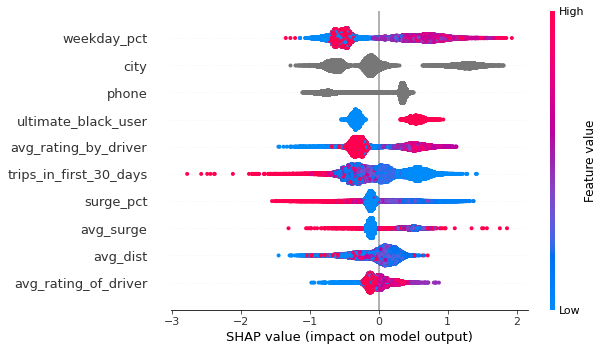

In [76]:
shap.summary_plot(shap_values, X)

3.3063178047223993

1.6584818566482882